# J407 ALMA with GAIA Astrometry plot
M Kenworthy // 17 December 2018


    pip install aplpy==1.1.1
    astropy 3.2.3

In [10]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.io import fits
from astropy.wcs import WCS

import matplotlib.pyplot as plt
%matplotlib inline
import aplpy
from astropy.time import Time

import astropy.coordinates
from astropy.coordinates import ICRS, ITRS, GCRS

import warnings; warnings.simplefilter('ignore')
print('aplpy version is:',aplpy.__version__)
print('astropy version is:',astropy.__version__)


aplpy version is: 1.1.1
astropy version is: 3.2.3


ALMA has a WCS attached to the image, which is an ICRS frame. This means that, regardless of when the data was taken, the frame is moved back to J2000.0 and moved to the barycenter of the Solar system.

I therefore believe that you do not need to correct for topocentric position (the observer on the Earth) because if everything is in the same ICRS and same equinox of J2000.0, then you can make a direct comparison of all astrometry.

In [11]:
from astropy.utils.data import get_pkg_data_filename

filename = get_pkg_data_filename('uid___A001_X87c_X409._1SWASP_J140747.93-394542.6__sci.spw17_19_21_23.cont.I.pbcor.fits')
hdu = fits.open(filename)[0]
hdu.data = hdu.data * 1.e6

## GAIA DR2 astrometry of J1407

Search for "V4100 Cen" a.k.a. J1407 in Gaia Data Release 2 (DR2) and use the query tool to get positions at eclipse epoch and at ALMA observation epoch

https://gea.esac.esa.int/archive/

The table line returned gives:

    | ID      | 6117085769513415168    |
    | RA      | 211.9495779478659      |
    | RA_err  | 0.040221262597747144   |
    | Dec     | -39.761970359990514    | 
    | Dec_err | 0.037195316385827806   | 
    | plx     | 7.183474683431726      |
    | plx_err | 0.044652824409147605   |

All positions are adjusted to 2015.5 for DR2, as seen at this page:
https://www.cosmos.esa.int/web/gaia/dr2
    
"The reference epoch for Gaia DR2 is J2015.5 (compared to the J2015.0 epoch for Gaia DR1). Positions and proper motions are referred to the ICRS, to which the optical reference frame defined by Gaia DR2 is aligned. The time coordinate for Gaia DR2 results is the barycentric coordinate time (TCB)."


In [12]:
t_eclipse = Time('2007-04-30')
t_alma    = Time('2017-07-30')

dt = t_alma - t_eclipse

plx = 7.18347e-3
plx_err = 0.0446528244e-3
d1 = 1./(plx + plx_err)
d2 = 1./(plx - plx_err)
d_err = (d2 - d1) / 2.

print('Time of eclipse in Julian years: {:.4f}'.format(t_eclipse.jyear))
print('Time of ALMA observation in Julian years: {:.4f}'.format(t_alma.jyear))

print('delta in days is: {:.1f} days'.format(dt.value))
print('GAIA distance: {:.2f} +- {:.2f} pc'.format(1./plx,d_err))

Time of eclipse in Julian years: 2007.3251
Time of ALMA observation in Julian years: 2017.5756
delta in days is: 3744.0 days
GAIA distance: 139.21 +- 0.87 pc


## GAIA positions and errors for J1407

This uses ADQL queries to get the correctly propagated positions and errors for J1407 from the Gaia DR2 database.

Go to https://gea.esac.esa.int/archive/ and put these under the Advanced (ADQL) tab:

### 2007

```
SELECT EPOCH_PROP_POS(ra, dec, parallax, pmra, pmdec, radial_velocity, 2015.5, 2007.325119780) 
    FROM gaiadr2.gaia_source
    WHERE source_id = 6117085769513415168
```

(3.69921916846516 , -0.693976463829901)


### 2017

```
SELECT EPOCH_PROP_POS(ra, dec, parallax, pmra, pmdec, radial_velocity, 2015.5, 2017.57563312) 
    FROM gaiadr2.gaia_source
    WHERE source_id = 6117085769513415168
```

(3.69921768251056 , -0.693977512133849)

```
SELECT EPOCH_PROP_ERROR(
	ra, dec, parallax, pmra, pmdec, radial_velocity,
	ra_error, dec_error, parallax_error, pmra_error, pmdec_error, radial_velocity_error,
	ra_dec_corr, ra_parallax_corr, ra_pmra_corr, ra_pmdec_corr,
	dec_parallax_corr, dec_pmra_corr, dec_pmdec_corr,
	parallax_pmra_corr, parallax_pmdec_corr, pmra_pmdec_corr,
	2015.5, 2017.57563312)
FROM gaiadr2.gaia_source
WHERE source_id = 6117085769513415168
```

Error in position of J1407 in mas:

(0.1579698907237217,0.17611503230622214)


position of J1407 in 2017.5756331279945 is 14h07m47.8946s -39d45m43.1371s
61.108952891168066 arcsec pc
separation of ALMA source from J1407 is 0.438974329825119 arcsec
INFO: Setting slices=[0, 0] [aplpy.core]


transverse velocity of ring system is 33.57 km / s+-5.25 km / s:
free floating angular distance (solid white circle) is 0.522 arcsec+-0.081 arcsec
cbar: None
INFO: Auto-setting resolution to 39.038 dpi [aplpy.core]


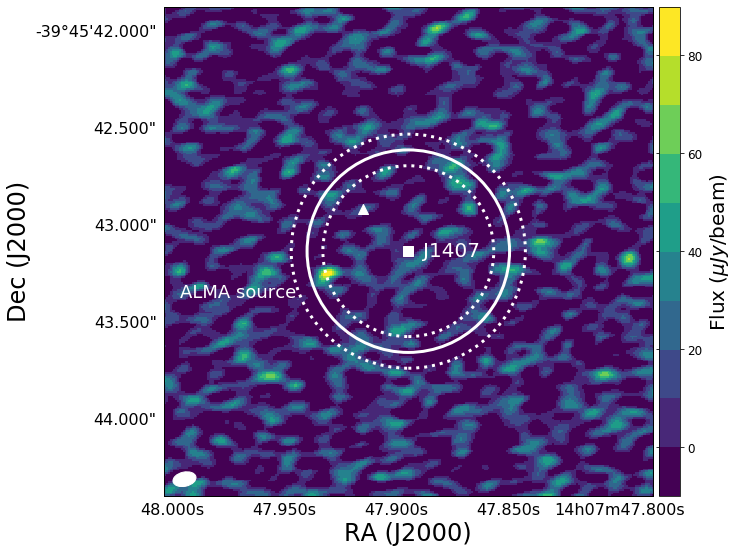

In [15]:
# ALMA source measured by Pamela Klaassen
ALMA_source = SkyCoord('14h07m47.93110s', '-39d45m43.26068s', frame='icrs')

# error on RA is  6.2 mas
# error on Dec is 3.8 mas
# a size of 95.1+-18.1 mas by  58.4+-6.1mas at a position angle of 113.4$\pm 8.4^\circ$

c_gaia_alma = SkyCoord(3.69921768251056 * u.rad, -0.693977512133849 * u.rad, frame='icrs')

print('position of J1407 in {} is {}'.format(t_alma.jyear,c_gaia_alma.to_string('hmsdms')))


alma_source_gaia_j1407 = c_gaia_alma.separation(ALMA_source).to(u.arcsec)

print((alma_source_gaia_j1407 * (1./plx)*u.parsec))

print('separation of ALMA source from J1407 is {}'.format(alma_source_gaia_j1407))

c_gaia_ecli = SkyCoord(3.69921916846516 * u.rad, -0.693976463829901 * u.rad, frame='icrs')

### %config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
fig2 = aplpy.FITSFigure(hdu)

fig2.show_colorscale(vmin=-10,vmax=90.,cmap=plt.cm.get_cmap('viridis',10))

# ALMA source label
fig2.add_label(ALMA_source.ra.deg+0.20/3600., ALMA_source.dec.deg-0.09/3600., 'ALMA source', color='white', size=18, horizontalalignment='right')

fig2.add_label(c_gaia_alma.ra.deg-0.1/3600., c_gaia_alma.dec.deg, 'J1407', color='white', size=20, horizontalalignment='left')

fig2.show_markers(c_gaia_alma.ra.deg, c_gaia_alma.dec.deg, s=100, edgecolor='white', marker='s',facecolor='white')
fig2.show_markers(c_gaia_ecli.ra.deg, c_gaia_ecli.dec.deg, s=100, edgecolor='white', marker='^',facecolor='white')

# what's the angular separation for a free floating object at J1407 between eclipse and ALMA observations?
j1407_dist = (1./plx) * u.parsec

frac_star_radius_error = 0.15/0.96

# equation 12 from vW 2014 MNRAS, with radius of star from Mamajek 2012.
v_trans = 13. * 3.04 * (0.96 / 1.13) * u.km / u.s

v_trans_err = v_trans * frac_star_radius_error # dominant error is from J1407 stellar radius

print('transverse velocity of ring system is {:.2f}+-{:.2f}:'.format(v_trans,v_trans_err))

# 3.04 is meaured light curve gradient vW 2014 MNRAS, Table 5, 
free_dist = ((v_trans * dt) / j1407_dist).to(u.arcsec, equivalencies=u.equivalencies.dimensionless_angles())

# error on the free floating radius
free_dist_err = free_dist * frac_star_radius_error # main limit is the fractional error on the radius of the star

print('free floating angular distance (solid white circle) is {:.3f}+-{:.3f}'.format(free_dist.to(u.arcsec),free_dist_err))

fig2.show_circles(c_gaia_alma.ra.deg, c_gaia_alma.dec.deg, free_dist.to(u.deg).value, color='white', linewidth=3)
fig2.show_circles(c_gaia_alma.ra.deg, c_gaia_alma.dec.deg, (free_dist-free_dist_err).to(u.deg).value, color='white', linestyle='dotted',linewidth=3)
fig2.show_circles(c_gaia_alma.ra.deg, c_gaia_alma.dec.deg, (free_dist+free_dist_err).to(u.deg).value, color='white', linestyle='dotted', linewidth=3)

# move this to the centre
cbar = fig2.add_colorbar()
print('cbar:',cbar)
fig2.colorbar.set_pad(0.08)
fig2.colorbar.set_axis_label_text('Flux ($\mu Jy$/beam)')
fig2.colorbar.set_axis_label_font(size=20)


fig2.recenter(c_gaia_alma.ra.deg, c_gaia_alma.dec.deg,width=0.0014/2.,height=0.0014/2.)


# tidy up the image
fig2.tick_labels.set_xformat('hh:mm:ss.sss')
fig2.tick_labels.set_yformat('dd:mm:ss.sss')
fig2.add_grid()

fig2.add_beam()
fig2.beam.set_color('white')
fig2.beam.set_hatch('+')
fig2.axis_labels.set_font(size=24)
fig2.tick_labels.set_font(size=16)

fig2.colorbar.set_font(size='large', weight='medium', \
                      stretch='normal', family='sans-serif', \
                      style='normal', variant='normal')

fig2.colorbar.set_width(0.3)
fig2.remove_grid()
fig2.refresh()

fig2.save('j1407_alma_gaia_astrometry_plot.pdf')